<a href="https://colab.research.google.com/github/vvamsi91/HGR_Project/blob/main/Resnet_HGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
import random
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
import kagglehub
gti_upm_leapgestrecog_path = kagglehub.dataset_download('gti-upm/leapgestrecog')

print('Data source import complete.')

Data source import complete.


In [3]:
import os
import numpy as np
import pandas as pd

# Define the input directory
input_dir = '/kaggle/input'

# Explore the directory structure
file_list = []
for root, _, files in os.walk(input_dir):
    for file in files:
        file_path = os.path.join(root, file)
        file_list.append(file_path)

print("Images are downloaded.")

Images are downloaded.


In [4]:
def Create_Directory_DataFrame():
    df_list = []
    basedir = '/kaggle/input/leapgestrecog/leapGestRecog/'
    for folder in os.listdir(basedir):
        for Class in os.listdir(basedir+folder+'/'):
            for location in os.listdir(basedir+folder+'/'+Class+'/'):
                df_list.append(pd.DataFrame([{'Class':Class,'Location':basedir+folder+'/'+Class+'/'+location}]))
    df = pd.concat(df_list, ignore_index=True)
    df = df.sample(frac = 1)
    return df

In [5]:
df = Create_Directory_DataFrame()
print(df.shape)
df.head()

(20000, 2)


Class                                           Location
18202  04_fist_moved  /kaggle/input/leapgestrecog/leapGestRecog/01/0...
4470            09_c  /kaggle/input/leapgestrecog/leapGestRecog/06/0...
4854        06_index  /kaggle/input/leapgestrecog/leapGestRecog/06/0...
14318  04_fist_moved  /kaggle/input/leapgestrecog/leapGestRecog/09/0...
11330          07_ok  /kaggle/input/leapgestrecog/leapGestRecog/00/0...

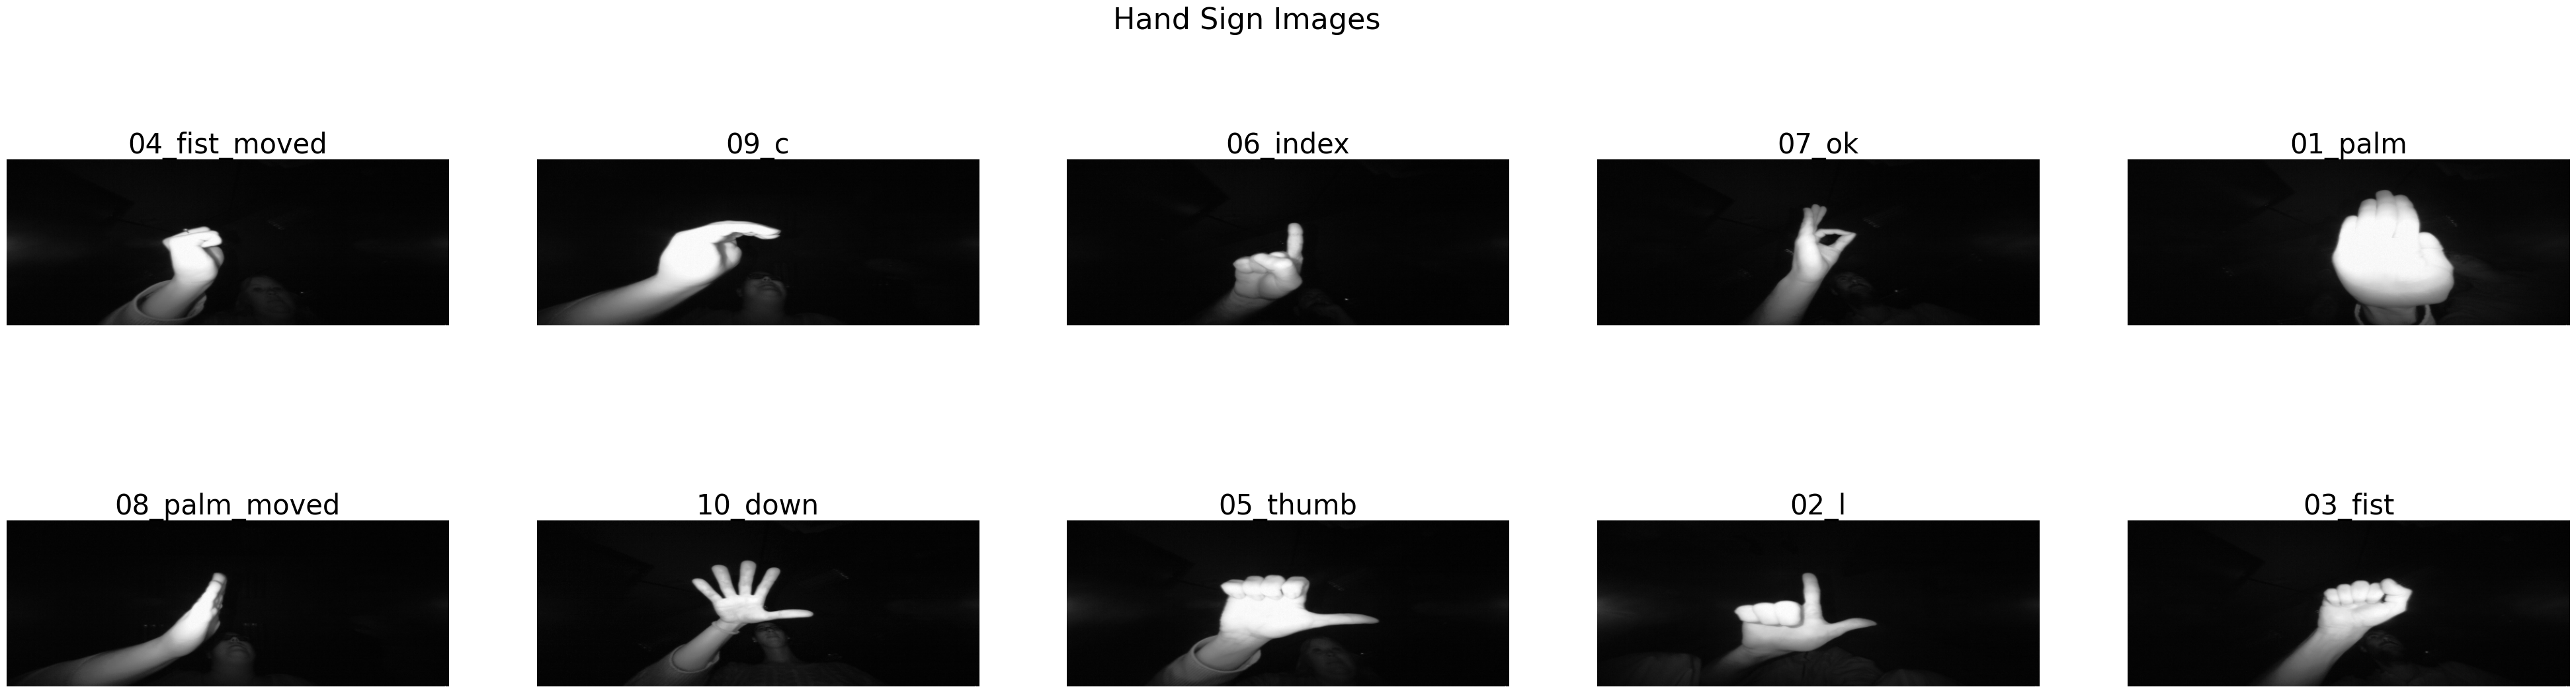

In [6]:
f = plt.figure(figsize=(50, 13))
count = 1

for gesture_class in df['Class'].unique():
    sample_row = df[df['Class'] == gesture_class].sample().iloc[0]
    img_path = sample_row['Location']
    img = cv2.imread(img_path, 0)

    ax = f.add_subplot(2, 5, count)
    ax.imshow(img, cmap='gray')
    ax.set_title(gesture_class, fontsize=30)
    ax.axis('off')

    count += 1

plt.suptitle("Hand Sign Images", fontsize=32)
plt.show()


In [7]:
img.shape

(240, 640)

In [8]:
w , h= 32,32
final_class = 10

In [9]:
from tqdm import tqdm

train_images = []

for path in tqdm(df['Location']):
    image = cv2.imread(path, 0)
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
    image = image.reshape(w, h, 1)
    train_images.append(image)

X = np.array(train_images)

100%|██████████| 20000/20000 [03:08<00:00, 105.92it/s]


In [10]:
from sklearn.preprocessing import OneHotEncoder

y = df['Class'].values.reshape(-1, 1)
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(y)

print(encoder.categories_)

[array(['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
       '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'],
      dtype=object)]


In [11]:
y = encoder.transform(y).toarray()

In [12]:
print('Data   :   '+str(X.shape))
print('Output :   '+str(y.shape))

Data   :   (20000, 32, 32, 1)
Output :   (20000, 10)


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [14]:
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(18000, 32, 32, 1)
Test data     :(2000, 32, 32, 1)
Train Output  :(18000, 10)
Test Output   :(2000, 10)


In [15]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add

def create_model(activation_func, num_classes, width, height):
    input_layer = Input(shape=(width, height, 1))

    conv_layer = Conv2D(3, kernel_size=3, padding='same', activation='relu')(input_layer)

    resnet_base = tf.keras.applications.ResNet152V2(
        weights='imagenet',
        include_top=False,
        pooling=None
    )(conv_layer)

    flat = Flatten()(resnet_base)
    dense1 = Dense(1024, activation='relu')(flat)
    dense2 = Dense(1024, activation='relu')(dense1)
    dense3 = Dense(256, activation='relu')(dense2)
    dense4 = Dense(128, activation='relu')(dense3)
    dense5 = Dense(64, activation='relu')(dense4)

    output_layer = Dense(num_classes, activation='sigmoid')(dense5)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

md = create_model('softmax', final_class, w, h)


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
md.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 1, 1, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,783,656 (235.69 MB)

 Trainable params: 61,639,912 (235.14 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [17]:
def wrap_results(results_df, optimizer_name, activation_name, history):
    num_epochs = len(history.history['loss'])
    epoch_list = list(range(1, num_epochs + 1))
    optim_list = [optimizer_name] * num_epochs
    act_list = [activation_name] * num_epochs

    data = {
        'Epochs': epoch_list,
        'Optimizer': optim_list,
        'Activation_Function': act_list,
        'Train_Loss': history.history['loss'],
        'Train_Accuracy': history.history['accuracy'],
        'Train_Precision': history.history['precision'],
        'Train_Recall': history.history['recall'],
        'Val_Loss': history.history['val_loss'],
        'Val_Accuracy': history.history['val_accuracy'],
        'Val_Precision': history.history['val_precision'],
        'Val_Recall': history.history['val_recall']
    }

    df_to_add = pd.DataFrame(data)
    results_df = pd.concat([results_df, df_to_add], ignore_index=True)
    return results_df


In [18]:
Optimisers = ['Adam','Adadelta','Adagrad']
Activation_function =['relu','sigmoid','softmax']

In [19]:
def plot_training_history(history, file_name, model):
    model.save(file_name + '.h5')
    epoch_numbers = list(range(1, len(history.history['loss']) + 1))

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy")
    )

    fig.add_trace(go.Scatter(x=epoch_numbers, y=history.history['loss']), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_numbers, y=history.history['accuracy']), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_numbers, y=history.history['val_loss']), row=2, col=1)
    fig.add_trace(go.Scatter(x=epoch_numbers, y=history.history['val_accuracy']), row=2, col=2)

    fig.update_layout(showlegend=False, height=1000, width=1200, title_text=file_name)
    pyo.iplot(fig, filename='Act_train_rec')

In [20]:
def build_model(act , final_class , w , h ):
    inp1 = Input(shape=(w,h,1,))
    new_input = Input(shape=(w,h, 3))
    conv1 = Conv2D(3, kernel_size=3, padding ='same', activation='relu')(inp1)
    i1 = tf.keras.applications.ResNet152V2(weights='imagenet',
                                include_top=False,
                                input_shape=None,
                         pooling=None,
                    )(conv1)
    i1 = tf.keras.layers.Flatten()(i1)
    i1 = Dense(1024, activation='relu')(i1)
    i1 = Dense(1024, activation='relu')(i1)
    class1 = Dense(256, activation='relu')(i1)
    class1 = Dense(128, activation='relu')(class1)
    class1 = Dense(64, activation='relu')(class1)
    output = Dense(final_class, activation='sigmoid')(class1)
    model = Model(inputs=inp1, outputs=output)
    return model

In [21]:
model = build_model(Activation_function[1], final_class, w, h)

metrics = ['accuracy']

model.compile(
    optimizer='RMSprop',
    loss='categorical_crossentropy',
    metrics=metrics
)

history = model.fit(
    X, y,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=True
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 953s 3s/step - accuracy: 0.1420 - loss: 2.2708 - val_accuracy: 0.1880 - val_loss: 2.2032
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 942s 3s/step - accuracy: 0.1906 - loss: 2.0549 - val_accuracy: 0.2025 - val_loss: 1.9879
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 969s 3s/step - accuracy: 0.1962 - loss: 1.9920 - val_accuracy: 0.1985 - val_loss: 1.9923
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 974s 3s/step - accuracy: 0.1969 - loss: 1.9839 - val_accuracy: 0.2105 - val_loss: 1.9904
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 929s 3s/step - accuracy: 0.2037 - loss: 1.9817 - val_accuracy: 0.2105 - val_loss: 1.9834
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 983s 3s/step - accuracy: 0.1992 - loss: 1.9980 - val_accuracy: 0.2025 - val_loss: 1.9868
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 985s 3s/step - accuracy: 0.1967 - loss: 1.9921 - val_accuracy: 0.2105 - val_loss: 1.9860
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 994s 3s/step - accuracy: 0.1962 - loss: 1.9802 - val_accu

In [24]:
plot_training_history(history , 'final_model',model)

In [23]:
! pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 22.2 MB/s eta 0:00:00


In [25]:
y_pred = model.evaluate(X_test , y_test,verbose =1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 791ms/step - accuracy: 0.1908 - loss: 1.9832


In [26]:
y_pred[1]

0.19550000131130219

In [31]:
import plotly.graph_objects as go


fig = go.Figure(data=[
    go.Bar(name = 'Accuracy',x=['Training','Validation','Real World Data'], y=[history.history['accuracy'][-1] ,history.history['val_accuracy'][-1],y_pred[1] ]),
    go.Bar(name = 'Loss',x=['Training','Validation','Real World Data'], y=[history.history['loss'][-1] ,history.history['val_loss'][-1],y_pred[0] ]),

])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(type = "log")
pyo.iplot(fig, filename = 'Act_train_rec')

In [32]:
model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 639ms/step


array([[0.52631325, 0.5173999 , 0.51234525, ..., 0.00200046, 0.51051646,
        0.51440907],
       [0.52631325, 0.5173999 , 0.51234525, ..., 0.00200046, 0.51051646,
        0.51440907],
       [0.52631325, 0.5173999 , 0.51234525, ..., 0.00200046, 0.51051646,
        0.51440907],
       ...,
       [0.52631325, 0.5173999 , 0.51234525, ..., 0.00200046, 0.51051646,
        0.51440907],
       [0.52631325, 0.5173999 , 0.51234525, ..., 0.00200046, 0.51051646,
        0.51440907],
       [0.52631325, 0.5173999 , 0.51234525, ..., 0.00200046, 0.51051646,
        0.51440907]], dtype=float32)

In [33]:
y_prediction = model.predict(X_test)

def binary_classify(predictions):
    for row in predictions:
        max_val = 0
        max_idx = 0
        for j in range(10):
            if max_val != max(max_val, row[j]):
                max_val = max(max_val, row[j])
                max_idx = j
            row[j] = 0
        row[max_idx] = 1
    return predictions

y_prediction = binary_classify(y_prediction)


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 650ms/step


In [35]:
def create_result(y):
    output = []
    for i in range(y.shape[0]):
        output.append(encoder.inverse_transform(y[i].reshape(1, 10))[0][0])
    return output

def remove_none(y, y_pred):
    for i in range(len(y) - 1, 0, -1):
        if y_pred[i] is None:
            del y[i]
            del y_pred[i]
    return y, y_pred

def label_encode(y, y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y)
    print(le.classes_)
    y = le.transform(y)
    y_pred = le.transform(y_pred)
    return y, y_pred

y_class_result = create_result(y_prediction)
y_class_desired = create_result(y_test)

In [36]:
y_label_desired , y_label_result = label_encode(y_class_desired , y_class_result)

['01_palm' '02_l' '03_fist' '04_fist_moved' '05_thumb' '06_index' '07_ok'
 '08_palm_moved' '09_c' '10_down']


In [38]:
from sklearn.metrics import classification_report
tn = []
for cat in encoder.categories_[0].reshape(10,1):
    tn.append(cat[0])
target_names = tn
print(classification_report(y_label_desired, y_label_result, target_names=target_names))

               precision    recall  f1-score   support

      01_palm       0.11      1.00      0.19       193
         02_l       0.00      0.00      0.00       215
      03_fist       0.00      0.00      0.00       183
04_fist_moved       0.00      0.00      0.00       199
     05_thumb       0.00      0.00      0.00       190
     06_index       0.00      0.00      0.00       193
        07_ok       0.00      0.00      0.00       207
08_palm_moved       1.00      1.00      1.00       198
         09_c       0.00      0.00      0.00       224
      10_down       0.00      0.00      0.00       198

     accuracy                           0.20      2000
    macro avg       0.11      0.20      0.12      2000
 weighted avg       0.11      0.20      0.12      2000



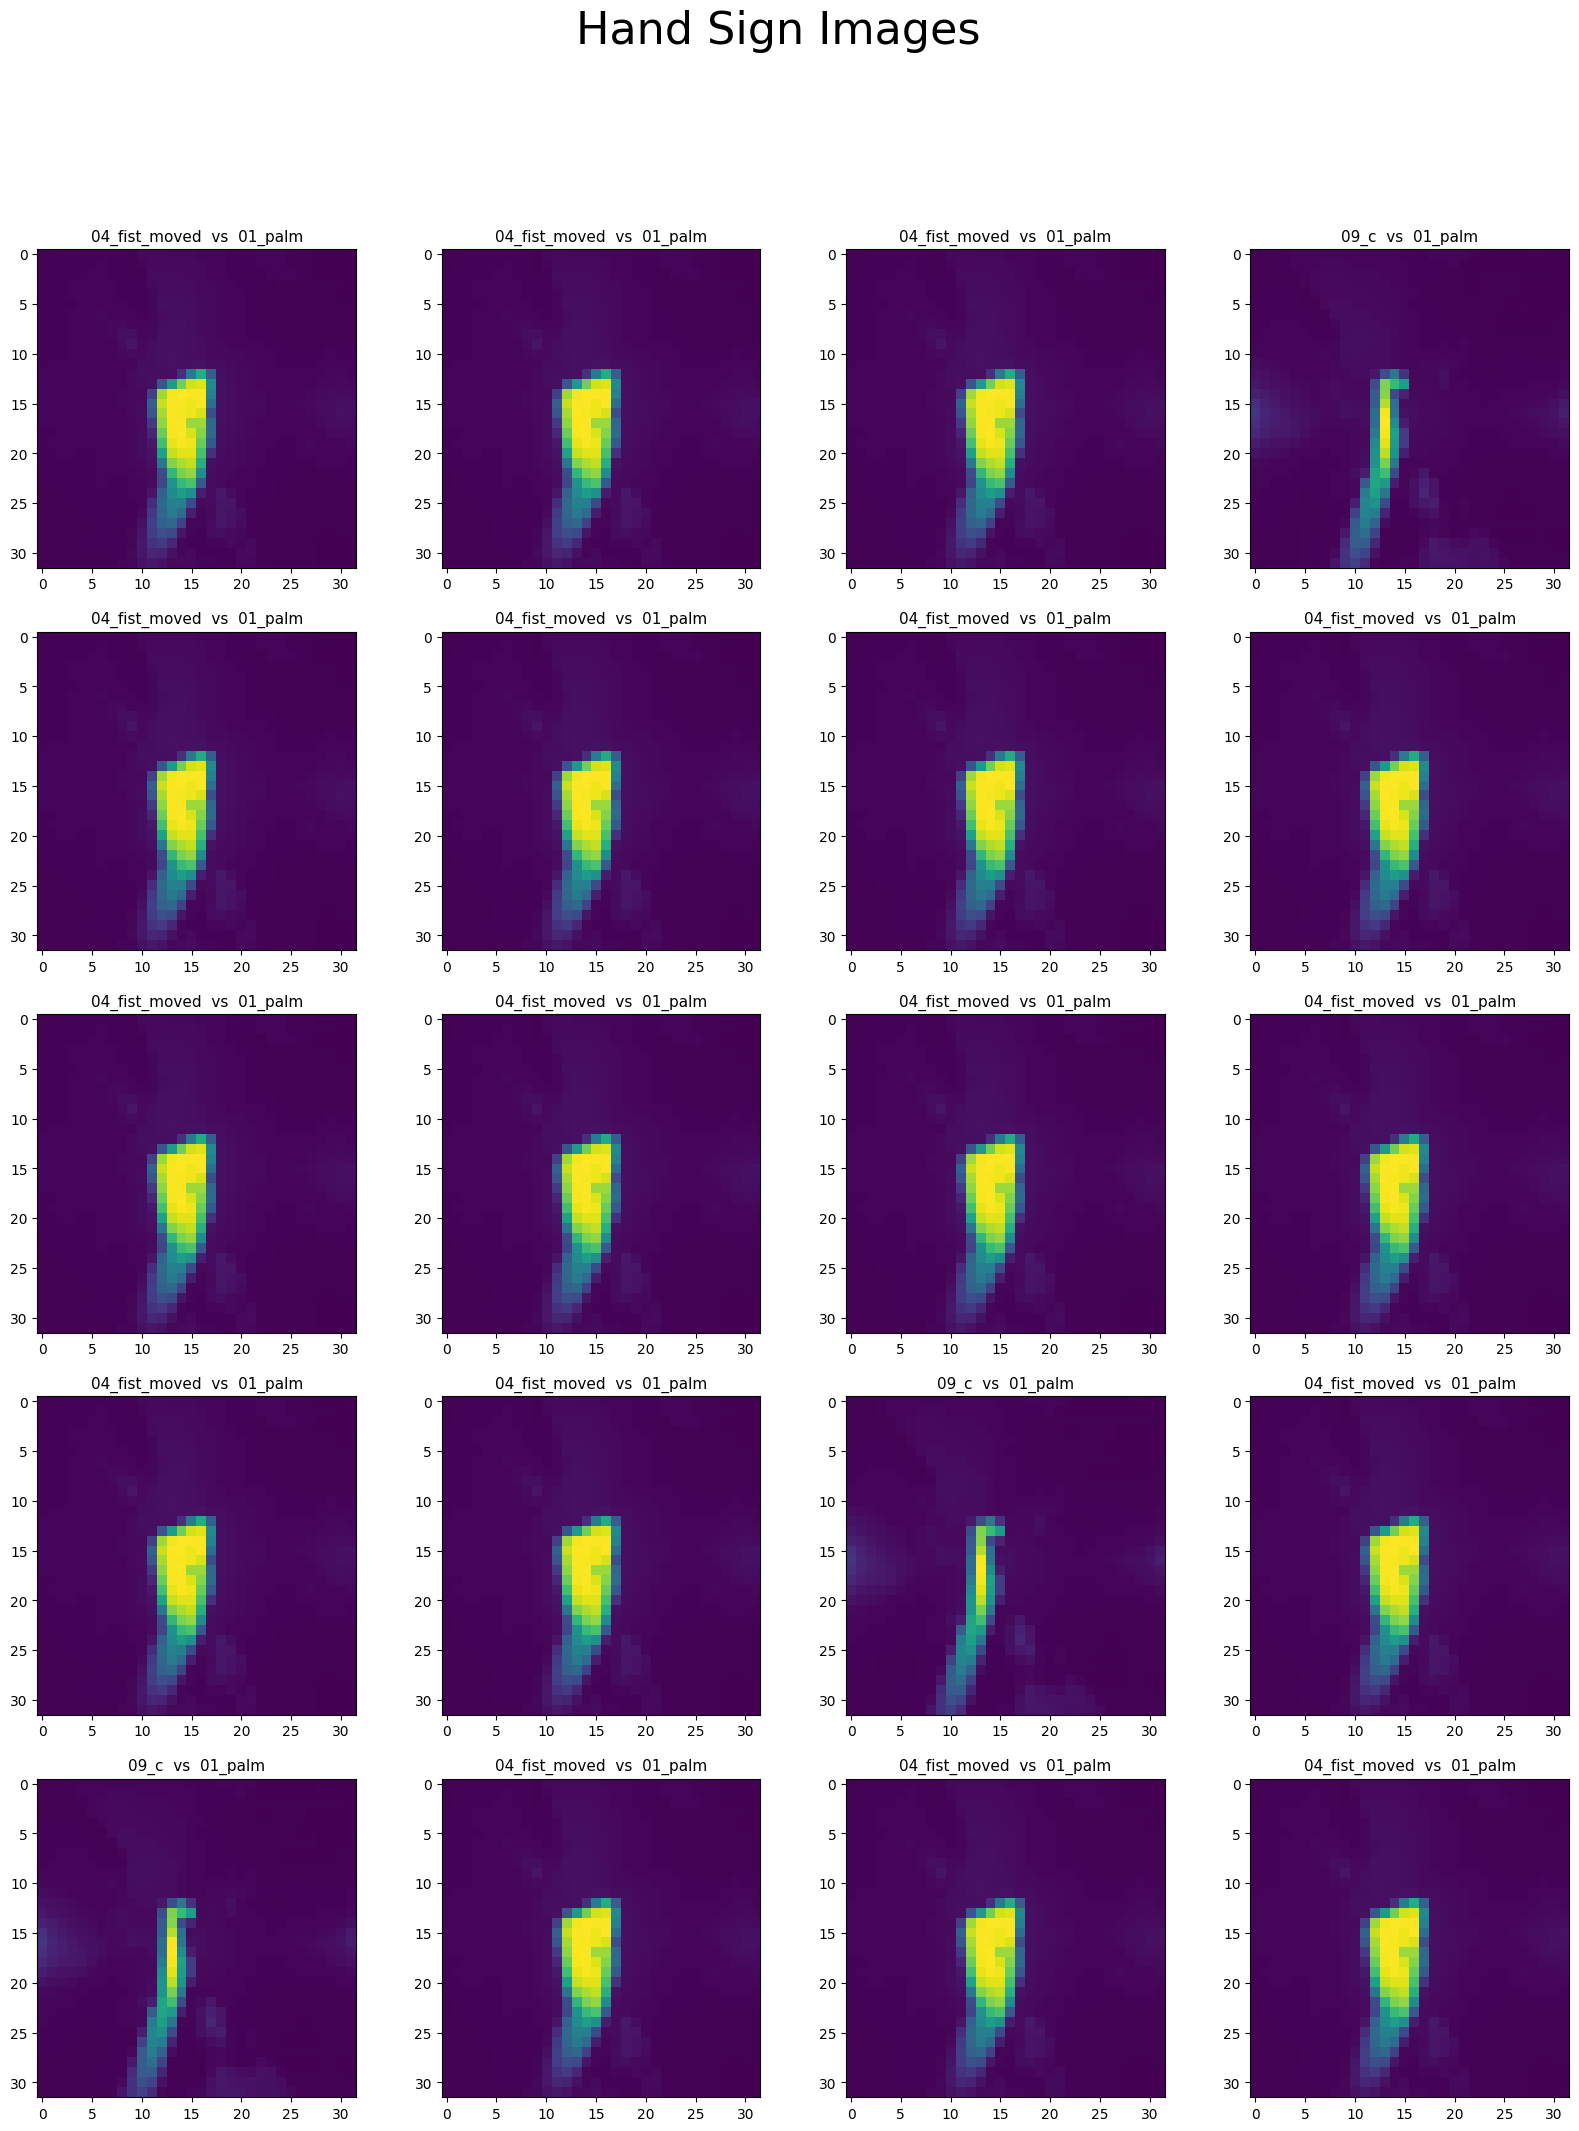

In [39]:
count = 1
f = plt.figure(figsize=(20,24))
for i in range(20):
    ind = random.sample(list(y_label_result),1)[0]
    img = X_test[ind]
    Class = str(y_class_desired[ind]) + '  vs  '+str(y_class_result[ind])
    ax = f.add_subplot(5, 4,count)
    ax = plt.imshow(img.reshape(w,h))
    ax = plt.title(Class,fontsize= 11)
    count = count + 1
plt.suptitle("Hand Sign Images", size = 32)
plt.show()
